In [1]:
# ==========================================
# KAGGLE SETUP: INSTALL REQUIRED LIBRARIES
# ==========================================
!pip install pretty_midi panns_inference

# =====================
# IMPORTS & BASIC SETUP
# =====================

import os
import glob
import warnings
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import librosa
import pretty_midi
import torchvision.models as models
import torchvision.transforms as T

from transformers import BertTokenizer, BertModel

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=5628aaf97250165bf6f8c846a171115e54def85ae36b0f1637457934c8f1254d
  Stored in directory: /root/.cache/pip/wheels/09/e6/e6/29223dbea25e71e517b8791bf35cc9a7b872cb2ad284e30181
Successfully built pretty_midi


2025-12-13 16:51:44.741642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765644704.888618      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765644704.934263      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


In [2]:
DATA_ROOT = "/kaggle/input/multimodal-mirex-emotion-dataset/dataset"
AUDIO_DIR = f"{DATA_ROOT}/Audio"
LYRICS_DIR = f"{DATA_ROOT}/Lyrics"
MIDI_DIR = f"{DATA_ROOT}/MIDIs"
CATEGORIES_TXT = f"{DATA_ROOT}/categories.txt"
CLUSTERS_TXT = f"{DATA_ROOT}/clusters.txt"

# Opsional: Jika dataset Anda masih dalam bentuk ZIP di Kaggle Input, 
# Anda bisa uncomment baris di bawah ini untuk meng-unzipnya ke folder kerja
# !unzip -q /kaggle/input/nama-dataset-anda/dataset.zip -d .

print("Paths configured")

Paths configured


In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

TEST_SIZE = 0.15
K_FOLDS = 3

LR_ENCODER = 1e-5
LR_FUSION = 1e-4
EPOCHS = 25
BATCH = 16

SR = 32000
AUDIO_LEN = 30

MAX_LEN_LYR = 256

WINDOW_SEC = 30
FS = 10

AUG_PROB = 0.5
MIXUP_ALPHA = 0.3
USE_TTA = True

print(f"Hyperparameters configured")
print(f"  K-Folds: {K_FOLDS}")
print(f"  LR: {LR_ENCODER} / {LR_FUSION}")
print(f"  Epochs: {EPOCHS}, Batch: {BATCH}")
print(f"  Augmentation Prob: {AUG_PROB}, Mixup Alpha: {MIXUP_ALPHA}")

Hyperparameters configured
  K-Folds: 3
  LR: 1e-05 / 0.0001
  Epochs: 25, Batch: 16
  Augmentation Prob: 0.5, Mixup Alpha: 0.3


In [4]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

TEST_SIZE = 0.15
K_FOLDS = 3

LR_ENCODER = 1e-5
LR_FUSION = 1e-4
EPOCHS = 25
BATCH = 16

SR = 32000
AUDIO_LEN = 30

MAX_LEN_LYR = 256

WINDOW_SEC = 30
FS = 10

AUG_PROB = 0.5
MIXUP_ALPHA = 0.3
USE_TTA = True

print(f"Hyperparameters configured")
print(f"  K-Folds: {K_FOLDS}")
print(f"  LR: {LR_ENCODER} / {LR_FUSION}")
print(f"  Epochs: {EPOCHS}, Batch: {BATCH}")
print(f"  Augmentation Prob: {AUG_PROB}, Mixup Alpha: {MIXUP_ALPHA}")

Hyperparameters configured
  K-Folds: 3
  LR: 1e-05 / 0.0001
  Epochs: 25, Batch: 16
  Augmentation Prob: 0.5, Mixup Alpha: 0.3


In [5]:
audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.mp3")))
file_ids = [os.path.splitext(os.path.basename(x))[0] for x in audio_files]

with open(CATEGORIES_TXT, "r", encoding="utf-8") as f:
    categories = [x.strip() for x in f.readlines()]

with open(CLUSTERS_TXT, "r", encoding="utf-8") as f:
    clusters = [x.strip() for x in f.readlines()]

categories = ["Aggressive" if c.lower() == "agressive" else c for c in categories]

meta_df = pd.DataFrame({
    "file_id": file_ids,
    "category": categories,
    "cluster_name": clusters
})

def parse_cluster_id(x: str):
    x = str(x)
    if x.lower().startswith("cluster"):
        return int(x.replace("Cluster", "").strip())
    return None

meta_df["cluster_id"] = meta_df["cluster_name"].apply(parse_cluster_id)
meta_df["audio_path"] = meta_df["file_id"].apply(lambda x: os.path.join(AUDIO_DIR, f"{x}.mp3"))
meta_df["lyrics_path"] = meta_df["file_id"].apply(lambda x: os.path.join(LYRICS_DIR, f"{x}.txt"))
meta_df["midi_path"] = meta_df["file_id"].apply(lambda x: os.path.join(MIDI_DIR, f"{x}.mid"))

meta_df["has_audio"] = meta_df["audio_path"].apply(os.path.exists)
meta_df["has_lyrics"] = meta_df["lyrics_path"].apply(os.path.exists)
meta_df["has_midi"] = meta_df["midi_path"].apply(os.path.exists)

meta_df["cluster_idx"] = meta_df["cluster_id"] - 1
num_classes = 5
cluster_labels = [f"Cluster_{i}" for i in range(1, 6)]

label_dict = dict(zip(meta_df["file_id"], meta_df["cluster_idx"]))

base_df = meta_df[meta_df["has_audio"]].reset_index(drop=True)
corrupt_midi = []

print(f"Total samples: {len(base_df)}")
print(f"Audio: {meta_df['has_audio'].sum()}")
print(f"Lyrics: {meta_df['has_lyrics'].sum()}")
print(f"MIDI: {meta_df['has_midi'].sum()}")

Total samples: 903
Audio: 903
Lyrics: 764
MIDI: 196


In [6]:
# ==========================================
# DOWNLOAD PRETRAINED WEIGHTS IF NOT EXIST
# ==========================================
weight_file = "Cnn14_mAP=0.431.pth"
if not os.path.exists(weight_file):
    print(f"Downloading {weight_file}...")
    # Mengunduh dari Zenodo (sumber resmi PANNs)
    !wget -O "Cnn14_mAP=0.431.pth" "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"
    print("Download complete.")
else:
    print(f"{weight_file} already exists.")

class TrainableAudioEncoder(nn.Module):
    def __init__(self, output_dim=512, device='cuda'):
        super().__init__()
        
        self.device = torch.device(device) if isinstance(device, str) else device
        
        from panns_inference.models import Cnn14
        
        self.panns_model = Cnn14(
            sample_rate=32000, 
            window_size=1024, 
            hop_size=320, 
            mel_bins=64, 
            fmin=50, 
            fmax=14000, 
            classes_num=527
        )
        
        # Load weights from current directory (downloaded above)
        checkpoint = torch.load("Cnn14_mAP=0.431.pth", map_location=self.device)
        self.panns_model.load_state_dict(checkpoint['model'])
        self.panns_model = self.panns_model.to(self.device)
        
        for param in self.panns_model.parameters():
            param.requires_grad = False
        
        for param in self.panns_model.fc1.parameters():
            param.requires_grad = True
        for param in self.panns_model.fc_audioset.parameters():
            param.requires_grad = True
        
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim)
        ).to(self.device)
    
    def forward(self, waveform):
        waveform = waveform.float().to(self.device)
        
        with torch.cuda.amp.autocast(enabled=False):
            output_dict = self.panns_model(waveform)
            embedding = output_dict['embedding']
        
        features = self.projection(embedding)
        return features

print("Audio Encoder ready")

--2025-12-13 16:52:04--  https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3987831/files/Cnn14_mAP=0.431.pth [following]
--2025-12-13 16:52:04--  https://zenodo.org/records/3987831/files/Cnn14_mAP=0.431.pth
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 327428481 (312M) [application/octet-stream]
Saving to: ‘Cnn14_mAP=0.431.pth’

Cnn14_mAP=0.431.pth 100%[===================>] 312.26M  24.1MB/s    in 22s     

2025-12-13 16:52:26 (14.3 MB/s) - ‘Cnn14_mAP=0.431.pth’ saved [327428481/327428481]

Download complete.
Audio Encoder ready


In [7]:
class TrainableLyricsEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        
        for param in self.bert.parameters():
            param.requires_grad = False
        
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        self.projection = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim),
            nn.LayerNorm(output_dim)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        
        mask_expanded = attention_mask.unsqueeze(-1).float()
        pooled = (hidden * mask_expanded).sum(1) / mask_expanded.sum(1).clamp(min=1e-6)
        
        features = self.projection(pooled)
        return features

print("Lyrics Encoder ready")

Lyrics Encoder ready


In [8]:
class TrainableMIDIEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        for param in resnet.parameters():
            param.requires_grad = False
        
        for param in resnet.layer3.parameters():
            param.requires_grad = True
        for param in resnet.layer4.parameters():
            param.requires_grad = True
        
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim),
            nn.LayerNorm(output_dim)
        )
    
    def forward(self, midi_img):
        x = self.features(midi_img)
        x = x.view(x.size(0), -1)
        features = self.projection(x)
        return features

print("MIDI Encoder ready")

MIDI Encoder ready


In [9]:
class BalancedDataset(Dataset):
    def __init__(self, file_ids, meta_df, label_dict, corrupt_midi, augment=False):
        self.file_ids = file_ids
        self.meta_df = meta_df
        self.label_dict = label_dict
        self.corrupt_midi = set(corrupt_midi)
        self.augment = augment
        
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        
        self.midi_transform = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.synonyms = {
            'love': ['adore', 'cherish', 'affection'], 'hate': ['despise', 'detest', 'loathe'],
            'happy': ['joyful', 'cheerful', 'glad'], 'sad': ['sorrowful', 'melancholy', 'unhappy'],
            'angry': ['furious', 'mad', 'enraged'], 'fear': ['afraid', 'scared', 'terrified'],
            'beautiful': ['lovely', 'gorgeous', 'stunning'], 'good': ['great', 'fine', 'excellent'],
            'bad': ['terrible', 'awful', 'poor'], 'big': ['large', 'huge', 'enormous'],
            'small': ['tiny', 'little', 'minute'], 'fast': ['quick', 'rapid', 'swift'],
            'slow': ['gradual', 'leisurely', 'unhurried']
        }
    
    def augment_audio(self, audio):
        if np.random.rand() > AUG_PROB:
            return audio
        
        if np.random.rand() < 0.5:
            rate = np.random.uniform(0.9, 1.1)
            audio = librosa.effects.time_stretch(audio, rate=rate)
        
        if np.random.rand() < 0.5:
            n_steps = np.random.uniform(-2, 2)
            audio = librosa.effects.pitch_shift(audio, sr=SR, n_steps=n_steps)
        
        if np.random.rand() < 0.3:
            noise = np.random.normal(0, np.random.uniform(0.002, 0.008), audio.shape)
            audio = audio + noise
        
        if np.random.rand() < 0.3:
            audio = audio * np.random.uniform(0.8, 1.2)
        
        return audio
    
    def augment_lyrics(self, text):
        if np.random.rand() > AUG_PROB:
            return text
        
        words = text.lower().split()
        augmented_words = []
        
        for word in words:
            if word in self.synonyms and np.random.rand() < 0.4:
                augmented_words.append(np.random.choice(self.synonyms[word]))
            elif np.random.rand() < 0.1:
                continue
            else:
                augmented_words.append(word)
        
        return ' '.join(augmented_words)
    
    def augment_midi(self, midi_img):
        if np.random.rand() > AUG_PROB:
            return midi_img
        
        if np.random.rand() < 0.4:
            midi_img = torch.flip(midi_img, dims=[2])
        
        if np.random.rand() < 0.4:
            midi_img = T.functional.rotate(midi_img, np.random.uniform(-10, 10))
        
        if np.random.rand() < 0.4:
            midi_img = torch.roll(midi_img, shifts=np.random.randint(-20, 20), dims=1)
        
        return midi_img
    
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, idx):
        fid = self.file_ids[idx]
        row = self.meta_df[self.meta_df.file_id == fid].iloc[0]
        
        try:
            audio, _ = librosa.load(row.audio_path, sr=SR, mono=True)
            max_len = SR * AUDIO_LEN
            
            if self.augment:
                audio = self.augment_audio(audio)
            
            if len(audio) < max_len:
                audio = np.pad(audio, (0, max_len - len(audio)))
            else:
                audio = audio[:max_len]
            
            audio = audio / (np.abs(audio).max() + 1e-8)
            audio = torch.FloatTensor(audio)
        except:
            audio = torch.zeros(SR * AUDIO_LEN)
        
        if row.has_lyrics:
            try:
                with open(row.lyrics_path, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                
                if self.augment:
                    text = self.augment_lyrics(text)
                
                enc = self.tokenizer(text, max_length=MAX_LEN_LYR, truncation=True, 
                                   padding='max_length', return_tensors='pt')
                lyrics_ids = enc['input_ids'].squeeze(0)
                lyrics_mask = enc['attention_mask'].squeeze(0)
            except:
                lyrics_ids = torch.zeros(MAX_LEN_LYR, dtype=torch.long)
                lyrics_mask = torch.zeros(MAX_LEN_LYR, dtype=torch.long)
        else:
            lyrics_ids = torch.zeros(MAX_LEN_LYR, dtype=torch.long)
            lyrics_mask = torch.zeros(MAX_LEN_LYR, dtype=torch.long)
        
        if row.has_midi and fid not in self.corrupt_midi:
            try:
                pm = pretty_midi.PrettyMIDI(row.midi_path)
                dur = pm.get_end_time()
                
                if dur > 0:
                    end = min(WINDOW_SEC, dur)
                    times = np.linspace(0, end, int(FS * end) + 1)
                    roll = pm.get_piano_roll(fs=FS, times=times)
                    roll = (roll > 0).astype(np.float32)
                    midi_img = self.midi_transform(roll)
                    
                    if self.augment:
                        midi_img = self.augment_midi(midi_img)
                else:
                    midi_img = torch.zeros(3, 224, 224)
            except:
                midi_img = torch.zeros(3, 224, 224)
        else:
            midi_img = torch.zeros(3, 224, 224)
        
        label = self.label_dict[fid]
        
        return audio, lyrics_ids, lyrics_mask, midi_img, label

print("Dataset ready")

Dataset ready


In [10]:
class AudioOnlyModel(nn.Module):
    def __init__(self, num_classes=5, hidden_dim=512, device='cuda'):
        super().__init__()
        
        self.encoder = TrainableAudioEncoder(output_dim=hidden_dim, device=device)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, audio, lyrics_ids=None, lyrics_mask=None, midi_img=None):
        feat = self.encoder(audio)
        return self.classifier(feat)

class LyricsOnlyModel(nn.Module):
    def __init__(self, num_classes=5, hidden_dim=512):
        super().__init__()
        
        self.encoder = TrainableLyricsEncoder(output_dim=hidden_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, audio=None, lyrics_ids=None, lyrics_mask=None, midi_img=None):
        feat = self.encoder(lyrics_ids, lyrics_mask)
        return self.classifier(feat)

class MIDIOnlyModel(nn.Module):
    def __init__(self, num_classes=5, hidden_dim=512):
        super().__init__()
        
        self.encoder = TrainableMIDIEncoder(output_dim=hidden_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, audio=None, lyrics_ids=None, lyrics_mask=None, midi_img=None):
        feat = self.encoder(midi_img)
        return self.classifier(feat)

print("Unimodal models ready")

Unimodal models ready


In [11]:
class IntermediateFusionModel(nn.Module):
    def __init__(self, num_classes=5, hidden_dim=512, device='cuda', fusion_type='attention'):
        super().__init__()
        
        self.audio_encoder = TrainableAudioEncoder(output_dim=hidden_dim, device=device)
        self.lyrics_encoder = TrainableLyricsEncoder(output_dim=hidden_dim)
        self.midi_encoder = TrainableMIDIEncoder(output_dim=hidden_dim)
        
        self.hidden_dim = hidden_dim
        self.fusion_type = fusion_type
        
        if fusion_type == 'concat':
            fusion_input_dim = hidden_dim * 3
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_input_dim, hidden_dim * 2),
                nn.LayerNorm(hidden_dim * 2),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.LayerNorm(hidden_dim)
            )
        
        elif fusion_type == 'attention':
            self.cross_attn = nn.MultiheadAttention(
                embed_dim=hidden_dim,
                num_heads=8,
                dropout=0.3,
                batch_first=True
            )
            
            self.self_attn = nn.MultiheadAttention(
                embed_dim=hidden_dim,
                num_heads=8,
                dropout=0.3,
                batch_first=True
            )
            
            self.modality_importance = nn.Parameter(torch.ones(3) / 3)
        
        elif fusion_type == 'bilinear':
            self.bilinear_audio_lyrics = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
            self.bilinear_audio_midi = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
            self.bilinear_lyrics_midi = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
            
            self.fusion_layer = nn.Sequential(
                nn.Linear(hidden_dim * 3, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU(),
                nn.Dropout(0.3)
            )
        
        elif fusion_type == 'gated':
            self.gate_audio = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())
            self.gate_lyrics = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())
            self.gate_midi = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())
            
            self.fusion_layer = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU()
            )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, audio, lyrics_ids, lyrics_mask, midi_img):
        audio_feat = self.audio_encoder(audio)
        lyrics_feat = self.lyrics_encoder(lyrics_ids, lyrics_mask)
        midi_feat = self.midi_encoder(midi_img)
        
        audio_mask = (audio.abs().sum(dim=1) > 1e-3).float()
        lyrics_mask_real = (lyrics_mask.sum(dim=1) > 5).float()
        midi_mask = (midi_img.abs().sum(dim=(1,2,3)) > 0.1).float()
        
        if self.fusion_type == 'concat':
            fused = torch.cat([audio_feat, lyrics_feat, midi_feat], dim=1)
            fused = self.fusion_layer(fused)
        
        elif self.fusion_type == 'attention':
            stacked = torch.stack([audio_feat, lyrics_feat, midi_feat], dim=1)
            presence_mask = torch.stack([audio_mask, lyrics_mask_real, midi_mask], dim=1).bool()
            
            attn_out, _ = self.cross_attn(stacked, stacked, stacked, key_padding_mask=~presence_mask)
            refined, _ = self.self_attn(attn_out, attn_out, attn_out, key_padding_mask=~presence_mask)
            
            importance = torch.softmax(self.modality_importance, dim=0)
            weights = torch.stack([audio_mask, lyrics_mask_real, midi_mask], dim=1)
            weights = weights * importance.unsqueeze(0)
            weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)
            
            fused = (refined * weights.unsqueeze(-1)).sum(dim=1)
        
        elif self.fusion_type == 'bilinear':
            audio_lyrics = self.bilinear_audio_lyrics(audio_feat, lyrics_feat)
            audio_midi = self.bilinear_audio_midi(audio_feat, midi_feat)
            lyrics_midi = self.bilinear_lyrics_midi(lyrics_feat, midi_feat)
            
            combined = torch.cat([audio_lyrics, audio_midi, lyrics_midi], dim=1)
            fused = self.fusion_layer(combined)
        
        elif self.fusion_type == 'gated':
            gate_a = self.gate_audio(audio_feat)
            gate_l = self.gate_lyrics(lyrics_feat)
            gate_m = self.gate_midi(midi_feat)
            
            gated_audio = audio_feat * gate_a * audio_mask.unsqueeze(1)
            gated_lyrics = lyrics_feat * gate_l * lyrics_mask_real.unsqueeze(1)
            gated_midi = midi_feat * gate_m * midi_mask.unsqueeze(1)
            
            combined = gated_audio + gated_lyrics + gated_midi
            fused = self.fusion_layer(combined)
        
        logits = self.classifier(fused)
        return logits

print("Intermediate Fusion models ready")

Intermediate Fusion models ready


In [12]:
base_ids = np.array(base_df["file_id"].tolist())
labels = np.array([label_dict[f] for f in base_ids])

idx = np.arange(len(base_ids))

idx_trval, idx_test = train_test_split(
    idx, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_SEED
)

trainval_ids = base_ids[idx_trval]
test_ids = base_ids[idx_test]

print(f"TrainVal: {len(trainval_ids)} samples")
print(f"Test: {len(test_ids)} samples")

train_labels = [label_dict[fid] for fid in trainval_ids]
test_labels = [label_dict[fid] for fid in test_ids]

print("\nTraining Distribution:")
train_dist = Counter(train_labels)
for cls in sorted(train_dist.keys()):
    print(f"  Cluster {cls+1}: {train_dist[cls]:3d} ({train_dist[cls]/len(train_labels)*100:.1f}%)")

print("\nTest Distribution:")
test_dist = Counter(test_labels)
for cls in sorted(test_dist.keys()):
    print(f"  Cluster {cls+1}: {test_dist[cls]:3d} ({test_dist[cls]/len(test_labels)*100:.1f}%)")

TrainVal: 767 samples
Test: 136 samples

Training Distribution:
  Cluster 1: 144 (18.8%)
  Cluster 2: 139 (18.1%)
  Cluster 3: 183 (23.9%)
  Cluster 4: 162 (21.1%)
  Cluster 5: 139 (18.1%)

Test Distribution:
  Cluster 1:  26 (19.1%)
  Cluster 2:  25 (18.4%)
  Cluster 3:  32 (23.5%)
  Cluster 4:  29 (21.3%)
  Cluster 5:  24 (17.6%)


In [13]:
def mixup_data(audio, lyrics_ids, lyrics_mask, midi_img, labels, alpha=0.3):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = audio.size(0)
    index = torch.randperm(batch_size).to(audio.device)
    
    mixed_audio = lam * audio + (1 - lam) * audio[index]
    mixed_midi = lam * midi_img + (1 - lam) * midi_img[index]
    mixed_lyrics_ids = lyrics_ids if lam > 0.5 else lyrics_ids[index]
    mixed_lyrics_mask = lyrics_mask if lam > 0.5 else lyrics_mask[index]
    
    labels_a, labels_b = labels, labels[index]
    
    return mixed_audio, mixed_lyrics_ids, mixed_lyrics_mask, mixed_midi, labels_a, labels_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model_class, model_name, trainval_ids, test_ids, meta_df, label_dict, 
                corrupt_midi, epochs=25, use_mixup=False):
    
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
    y_trainval = np.array([label_dict[f] for f in trainval_ids])
    
    class_counts = np.bincount(y_trainval)
    class_weights = 1.0 / np.sqrt(class_counts)
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    
    fold_models = []
    fold_accs = []
    all_train_losses, all_val_losses = [], []
    all_train_accs, all_val_accs = [], []
    
    scaler = GradScaler() if device.type == 'cuda' else None
    
    for fold, (tr_idx, va_idx) in enumerate(skf.split(trainval_ids, y_trainval), 1):
        print(f"\nFold {fold}/{K_FOLDS}")
        
        train_ids = trainval_ids[tr_idx]
        val_ids = trainval_ids[va_idx]
        
        train_ds = BalancedDataset(train_ids, meta_df, label_dict, corrupt_midi, augment=True)
        val_ds = BalancedDataset(val_ids, meta_df, label_dict, corrupt_midi, augment=False)
        
        train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=BATCH, num_workers=0)
        
        if model_name == "Audio-only":
            model = model_class(device=device).to(device)
        elif model_name in ["Lyrics-only", "MIDI-only"]:
            model = model_class().to(device)
        else:
            model = model_class(device=device).to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR_FUSION, weight_decay=1e-2)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        
        patience = 8
        patience_counter = 0
        best_fold_acc = 0
        best_fold_model = None
        
        fold_train_losses, fold_val_losses = [], []
        fold_train_accs, fold_val_accs = [], []
        
        for epoch in range(1, epochs + 1):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            
            for audio, lyrics_ids, lyrics_mask, midi_img, labels in train_loader:
                audio = audio.to(device)
                lyrics_ids = lyrics_ids.to(device)
                lyrics_mask = lyrics_mask.to(device)
                midi_img = midi_img.to(device)
                labels = labels.to(device)
                
                if use_mixup and np.random.rand() < 0.3:
                    audio, lyrics_ids, lyrics_mask, midi_img, labels_a, labels_b, lam = mixup_data(
                        audio, lyrics_ids, lyrics_mask, midi_img, labels, alpha=MIXUP_ALPHA
                    )
                    use_mix = True
                else:
                    use_mix = False
                
                optimizer.zero_grad()
                
                if scaler:
                    with autocast():
                        outputs = model(audio, lyrics_ids, lyrics_mask, midi_img)
                        if use_mix:
                            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                        else:
                            loss = criterion(outputs, labels)
                    
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(audio, lyrics_ids, lyrics_mask, midi_img)
                    if use_mix:
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                    else:
                        loss = criterion(outputs, labels)
                    
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                
                train_loss += loss.item() * labels.size(0)
                
                if not use_mix:
                    train_correct += (outputs.argmax(1) == labels).sum().item()
                    train_total += labels.size(0)
                else:
                    train_correct += ((outputs.argmax(1) == labels_a).float() * lam + 
                                     (outputs.argmax(1) == labels_b).float() * (1-lam)).sum().item()
                    train_total += labels_a.size(0)
            
            scheduler.step()
            
            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            
            with torch.no_grad():
                for audio, lyrics_ids, lyrics_mask, midi_img, labels in val_loader:
                    audio = audio.to(device)
                    lyrics_ids = lyrics_ids.to(device)
                    lyrics_mask = lyrics_mask.to(device)
                    midi_img = midi_img.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(audio, lyrics_ids, lyrics_mask, midi_img)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * labels.size(0)
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)
            
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            avg_train_loss = train_loss / train_total
            avg_val_loss = val_loss / val_total
            
            fold_train_losses.append(avg_train_loss)
            fold_val_losses.append(avg_val_loss)
            fold_train_accs.append(train_acc)
            fold_val_accs.append(val_acc)
            
            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch:2d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
                      f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f}")
            
            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = model
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        fold_accs.append(best_fold_acc)
        fold_models.append(best_fold_model)
        print(f"Fold {fold} Best Val Acc: {best_fold_acc:.4f}")
        
        all_train_losses.append(fold_train_losses)
        all_val_losses.append(fold_val_losses)
        all_train_accs.append(fold_train_accs)
        all_val_accs.append(fold_val_accs)
    
    print(f"\nMean Val Accuracy: {np.mean(fold_accs):.4f} +/- {np.std(fold_accs):.4f}")
    
    test_ds = BalancedDataset(test_ids, meta_df, label_dict, corrupt_midi, augment=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH, num_workers=0)
    
    y_true = []
    y_pred_ensemble = []
    
    for audio, lyrics_ids, lyrics_mask, midi_img, labels in test_loader:
        audio = audio.to(device)
        lyrics_ids = lyrics_ids.to(device)
        lyrics_mask = lyrics_mask.to(device)
        midi_img = midi_img.to(device)
        
        all_preds = []
        
        for model in fold_models:
            model.eval()
            
            with torch.no_grad():
                outputs = model(audio, lyrics_ids, lyrics_mask, midi_img)
                pred = torch.softmax(outputs, dim=1)
                all_preds.append(pred)
        
        ensemble_pred = torch.stack(all_preds).mean(dim=0)
        
        y_pred_ensemble.extend(ensemble_pred.argmax(1).cpu().numpy())
        y_true.extend(labels.numpy())
    
    test_acc = accuracy_score(y_true, y_pred_ensemble)
    
    print(f"\n{model_name} Test Accuracy: {test_acc:.4f}\n")
    print(classification_report(y_true, y_pred_ensemble, target_names=cluster_labels, digits=4))
    
    return {
        'model_name': model_name,
        'fold_models': fold_models,
        'fold_accs': fold_accs,
        'mean_val_acc': np.mean(fold_accs),
        'std_val_acc': np.std(fold_accs),
        'test_acc': test_acc,
        'y_true': y_true,
        'y_pred': y_pred_ensemble,
        'train_losses': all_train_losses,
        'val_losses': all_val_losses,
        'train_accs': all_train_accs,
        'val_accs': all_val_accs
    }

print("Training function ready")

Training function ready


In [14]:
print("COMPARING UNIMODAL vs MULTIMODAL (ATTENTION FUSION)\n")

results = {}

print("EXPERIMENT 1/4: Audio-only Model")
results['audio'] = train_model(
    model_class=AudioOnlyModel,
    model_name="Audio-only",
    trainval_ids=trainval_ids,
    test_ids=test_ids,
    meta_df=meta_df,
    label_dict=label_dict,
    corrupt_midi=corrupt_midi,
    epochs=EPOCHS,
    use_mixup=False
)

print("\nEXPERIMENT 2/4: Lyrics-only Model")
results['lyrics'] = train_model(
    model_class=LyricsOnlyModel,
    model_name="Lyrics-only",
    trainval_ids=trainval_ids,
    test_ids=test_ids,
    meta_df=meta_df,
    label_dict=label_dict,
    corrupt_midi=corrupt_midi,
    epochs=EPOCHS,
    use_mixup=False
)

print("\nEXPERIMENT 3/4: MIDI-only Model")
results['midi'] = train_model(
    model_class=MIDIOnlyModel,
    model_name="MIDI-only",
    trainval_ids=trainval_ids,
    test_ids=test_ids,
    meta_df=meta_df,
    label_dict=label_dict,
    corrupt_midi=corrupt_midi,
    epochs=EPOCHS,
    use_mixup=False
)

print("\nEXPERIMENT 4/4: Attention Fusion (Multimodal)")
results['attention'] = train_model(
    model_class=lambda **kwargs: IntermediateFusionModel(fusion_type='attention', **kwargs),
    model_name="Fusion-Attention",
    trainval_ids=trainval_ids,
    test_ids=test_ids,
    meta_df=meta_df,
    label_dict=label_dict,
    corrupt_midi=corrupt_midi,
    epochs=EPOCHS,
    use_mixup=True
)

print("\nAll experiments completed")

COMPARING UNIMODAL vs MULTIMODAL (ATTENTION FUSION)

EXPERIMENT 1/4: Audio-only Model

TRAINING: Audio-only

Fold 1/3


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

--2025-12-13 16:52:29--  http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 74.125.199.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14675 (14K) [application/octet-stream]
Saving to: ‘/root/panns_data/class_labels_indices.csv’

     0K .......... ....                                       100%  117M=0s

2025-12-13 16:52:29 (117 MB/s) - ‘/root/panns_data/class_labels_indices.csv’ saved [14675/14675]



Epoch  1 | Train: Loss=1.6633 Acc=0.1977 | Val: Loss=1.5720 Acc=0.2930
Epoch  5 | Train: Loss=1.4778 Acc=0.3914 | Val: Loss=1.4014 Acc=0.4180
Epoch 10 | Train: Loss=1.4596 Acc=0.4227 | Val: Loss=1.3649 Acc=0.4492
Epoch 15 | Train: Loss=1.4236 Acc=0.4168 | Val: Loss=1.3712 Acc=0.4453
Early stopping at epoch 19
Fold 1 Best Val Acc: 0.4570

Fold 2/3
Epoch  1 | Train: Loss=1.6387 Acc=0.2368 | Val: Loss=1.5399 Acc=0.3633
Epoch  5 | Train: Loss=1.4790 Acc=0.4070 | Val: Loss=1.4762 Acc=0.4375
Epoch 10 | Train: Loss=1.3626 Acc=0.4540 | Val: Loss=1.4833 Acc=0.4336
Epoch 15 | Train: Loss=1.3684 Acc=0.4560 | Val: Loss=1.5083 Acc=0.4180
Epoch 20 | Train: Loss=1.3467 Acc=0.5068 | Val: Loss=1.5106 Acc=0.4375
Early stopping at epoch 20
Fold 2 Best Val Acc: 0.4570

Fold 3/3
Epoch  1 | Train: Loss=1.6677 Acc=0.2031 | Val: Loss=1.5666 Acc=0.3765
Epoch  5 | Train: Loss=1.5060 Acc=0.3809 | Val: Loss=1.3338 Acc=0.5137
Epoch 10 | Train: Loss=1.4534 Acc=0.4043 | Val: Loss=1.3181 Acc=0.4627
Epoch 15 | Train: 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch  1 | Train: Loss=1.6440 Acc=0.2446 | Val: Loss=1.5840 Acc=0.2930
Epoch  5 | Train: Loss=1.3011 Acc=0.5421 | Val: Loss=1.4387 Acc=0.4336
Epoch 10 | Train: Loss=0.8148 Acc=0.8141 | Val: Loss=1.7494 Acc=0.4258
Epoch 15 | Train: Loss=0.6172 Acc=0.8865 | Val: Loss=1.9848 Acc=0.4258
Early stopping at epoch 15
Fold 1 Best Val Acc: 0.4766

Fold 2/3
Epoch  1 | Train: Loss=1.6516 Acc=0.2387 | Val: Loss=1.6278 Acc=0.2266
Epoch  5 | Train: Loss=1.3229 Acc=0.5068 | Val: Loss=1.5070 Acc=0.4258
Epoch 10 | Train: Loss=0.7764 Acc=0.8317 | Val: Loss=1.7922 Acc=0.4297
Epoch 15 | Train: Loss=0.6440 Acc=0.8689 | Val: Loss=1.9126 Acc=0.4453
Epoch 20 | Train: Loss=0.6118 Acc=0.8806 | Val: Loss=2.0220 Acc=0.4062
Early stopping at epoch 23
Fold 2 Best Val Acc: 0.4453

Fold 3/3
Epoch  1 | Train: Loss=1.6569 Acc=0.2148 | Val: Loss=1.5640 Acc=0.2980
Epoch  5 | Train: Loss=1.2623 Acc=0.5352 | Val: Loss=1.5746 Acc=0.3686
Epoch 10 | Train: Loss=0.7783 Acc=0.8008 | Val: Loss=1.8812 Acc=0.3686
Early stopping at 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


Epoch  1 | Train: Loss=1.6813 Acc=0.2114 | Val: Loss=1.6361 Acc=0.2305
Epoch  5 | Train: Loss=1.6376 Acc=0.2055 | Val: Loss=1.6065 Acc=0.2344
Epoch 10 | Train: Loss=1.5951 Acc=0.2544 | Val: Loss=1.6375 Acc=0.2422
Epoch 15 | Train: Loss=1.5225 Acc=0.3229 | Val: Loss=1.6714 Acc=0.2461
Early stopping at epoch 19
Fold 1 Best Val Acc: 0.2656

Fold 2/3
Epoch  1 | Train: Loss=1.6840 Acc=0.2192 | Val: Loss=1.6424 Acc=0.1758
Epoch  5 | Train: Loss=1.6330 Acc=0.2192 | Val: Loss=1.6250 Acc=0.2266
Epoch 10 | Train: Loss=1.6049 Acc=0.2368 | Val: Loss=1.6384 Acc=0.2383
Epoch 15 | Train: Loss=1.5524 Acc=0.2877 | Val: Loss=1.6538 Acc=0.2305
Early stopping at epoch 18
Fold 2 Best Val Acc: 0.2383

Fold 3/3
Epoch  1 | Train: Loss=1.6758 Acc=0.1992 | Val: Loss=1.6296 Acc=0.2196
Epoch  5 | Train: Loss=1.6319 Acc=0.2422 | Val: Loss=1.6157 Acc=0.2196
Epoch 10 | Train: Loss=1.5837 Acc=0.2480 | Val: Loss=1.6413 Acc=0.2471
Epoch 15 | Train: Loss=1.5275 Acc=0.3164 | Val: Loss=1.6334 Acc=0.2431
Epoch 20 | Train: 

In [15]:
comparison_df = pd.DataFrame({
    'Model': ['Audio-only', 'Lyrics-only', 'MIDI-only', 'Fusion-Attention'],
    'Type': ['Unimodal', 'Unimodal', 'Unimodal', 'Multimodal'],
    'Val Acc (Mean)': [
        results['audio']['mean_val_acc'], 
        results['lyrics']['mean_val_acc'],
        results['midi']['mean_val_acc'], 
        results['attention']['mean_val_acc']
    ],
    'Val Acc (Std)': [
        results['audio']['std_val_acc'], 
        results['lyrics']['std_val_acc'],
        results['midi']['std_val_acc'], 
        results['attention']['std_val_acc']
    ],
    'Test Acc': [
        results['audio']['test_acc'], 
        results['lyrics']['test_acc'],
        results['midi']['test_acc'], 
        results['attention']['test_acc']
    ]
})

print("FINAL COMPARISON: UNIMODAL vs MULTIMODAL")
print("=" * 80)
print(comparison_df.to_string(index=False))
print()

best_unimodal_acc = comparison_df[comparison_df['Type'] == 'Unimodal']['Test Acc'].max()
multimodal_acc = comparison_df[comparison_df['Type'] == 'Multimodal']['Test Acc'].values[0]
improvement = multimodal_acc - best_unimodal_acc

print(f"Best Unimodal: {best_unimodal_acc:.4f}")

print(f"Multimodal (Attention): {multimodal_acc:.4f}")
print(f"Improvement: +{improvement:.4f} ({improvement*100:.2f}%)")

FINAL COMPARISON: UNIMODAL vs MULTIMODAL
           Model       Type  Val Acc (Mean)  Val Acc (Std)  Test Acc
      Audio-only   Unimodal        0.481158       0.034121  0.477941
     Lyrics-only   Unimodal        0.439318       0.033130  0.360294
       MIDI-only   Unimodal        0.252936       0.011249  0.242647
Fusion-Attention Multimodal        0.507133       0.020852  0.470588

Best Unimodal: 0.4779
Multimodal (Attention): 0.4706
Improvement: +-0.0074 (-0.74%)


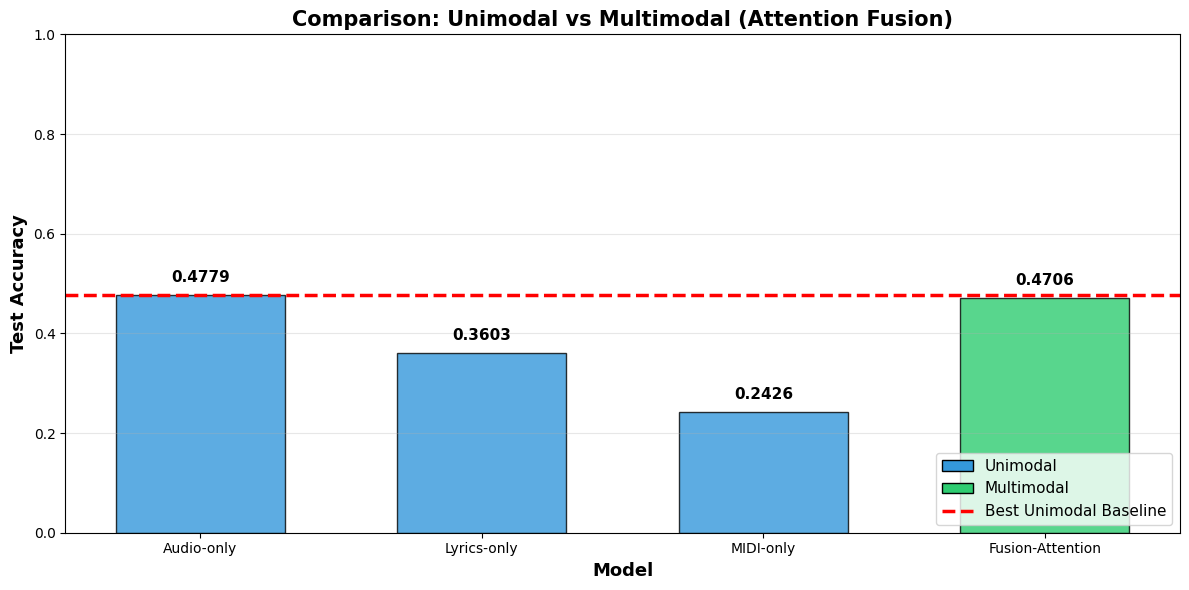

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

models = comparison_df['Model']
test_accs = comparison_df['Test Acc']
types = comparison_df['Type']

colors = ['#3498db' if t == 'Unimodal' else '#2ecc71' for t in types]
bars = ax.bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black', width=0.6)

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_title('Comparison: Unimodal vs Multimodal (Attention Fusion)', 
             fontsize=15, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=best_unimodal_acc, color='red', linestyle='--', linewidth=2.5, 
           label=f'Best Unimodal ({best_unimodal_acc:.4f})')

for i, (model, acc) in enumerate(zip(models, test_accs)):
    ax.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='black', label='Unimodal'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='Multimodal'),
    plt.Line2D([0], [0], color='red', linewidth=2.5, linestyle='--', 
               label='Best Unimodal Baseline')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

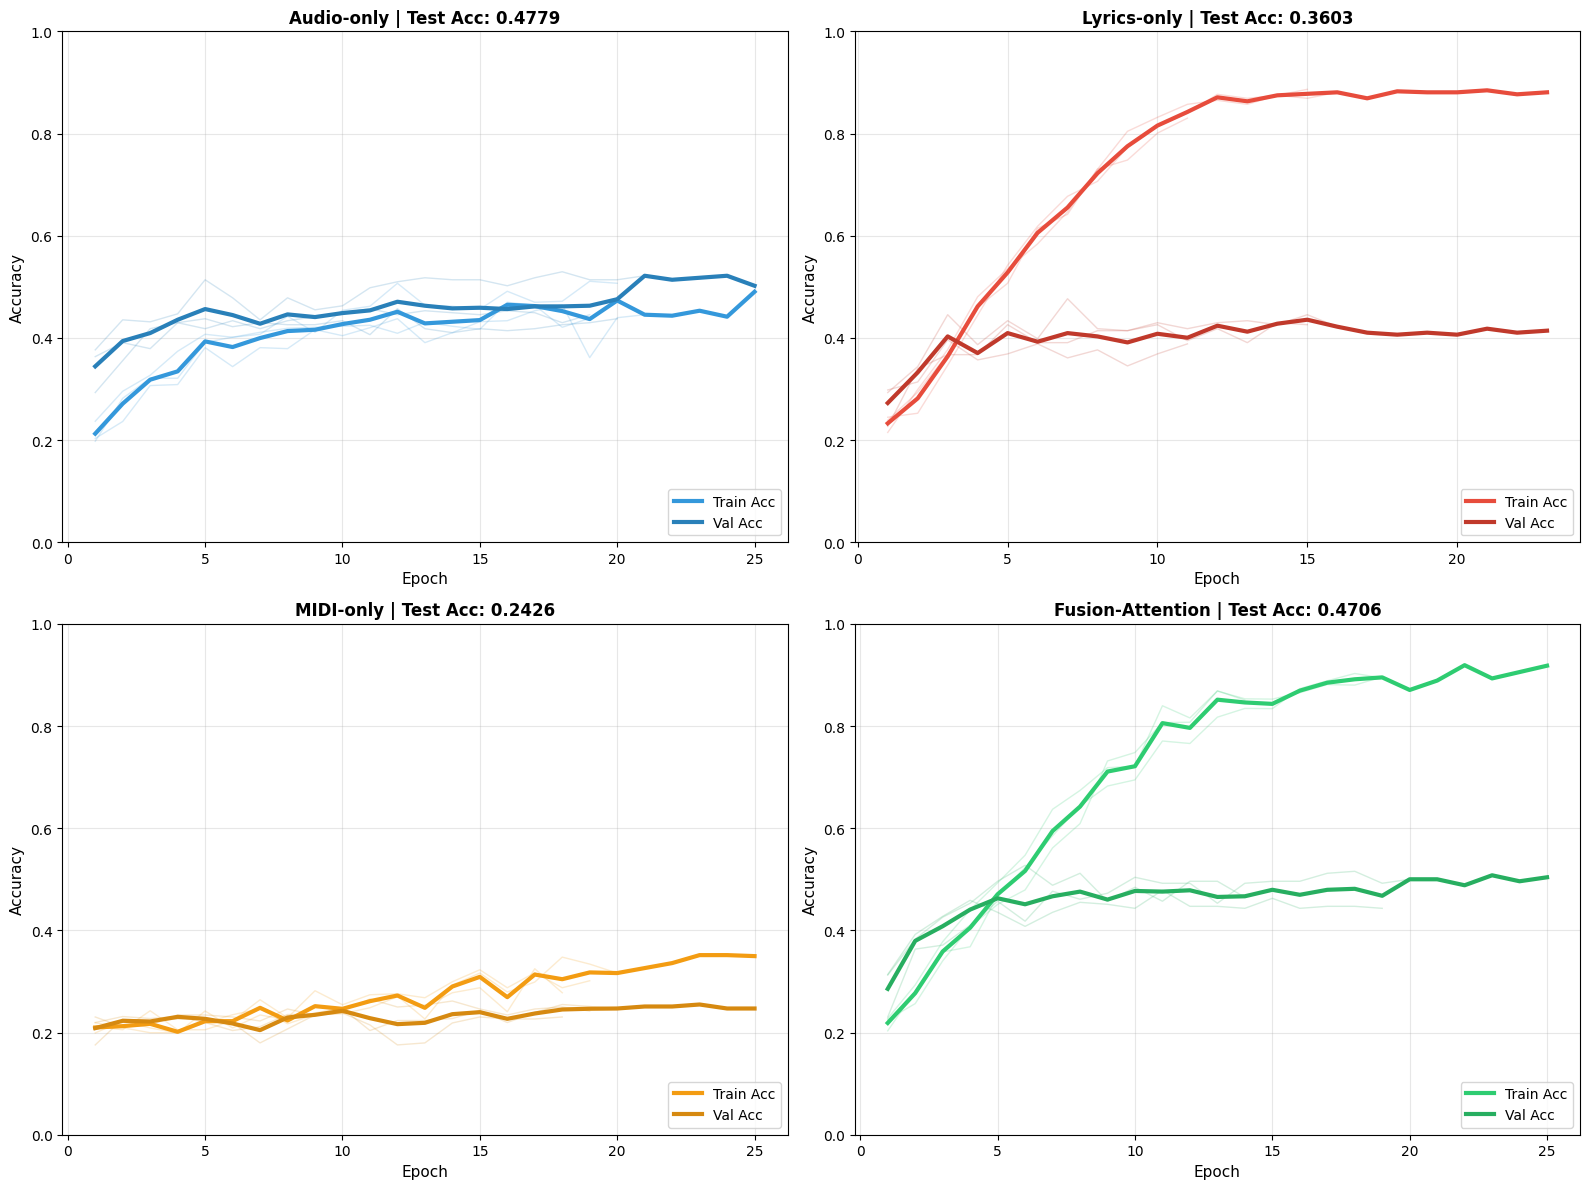

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = ['audio', 'lyrics', 'midi', 'attention']
titles = ['Audio-only', 'Lyrics-only', 'MIDI-only', 'Fusion-Attention']
colors_train = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
colors_val = ['#2980b9', '#c0392b', '#d68910', '#27ae60']

for idx, (key, title, color_t, color_v) in enumerate(zip(model_names, titles, colors_train, colors_val)):
    ax = axes[idx // 2, idx % 2]
    
    all_train_accs = results[key]['train_accs']
    all_val_accs = results[key]['val_accs']
    
    for train_acc, val_acc in zip(all_train_accs, all_val_accs):
        epochs = range(1, len(train_acc) + 1)
        ax.plot(epochs, train_acc, alpha=0.2, color=color_t, linewidth=1)
        ax.plot(epochs, val_acc, alpha=0.2, color=color_v, linewidth=1)
    
    max_len = max(len(x) for x in all_train_accs)
    avg_train_acc = [np.mean([fold[i] for fold in all_train_accs if i < len(fold)]) for i in range(max_len)]
    avg_val_acc = [np.mean([fold[i] for fold in all_val_accs if i < len(fold)]) for i in range(max_len)]
    
    epochs = range(1, len(avg_train_acc) + 1)
    ax.plot(epochs, avg_train_acc, color=color_t, linewidth=3, label='Train Acc')
    ax.plot(epochs, avg_val_acc, color=color_v, linewidth=3, label='Val Acc')
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{title} | Test Acc: {results[key]["test_acc"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

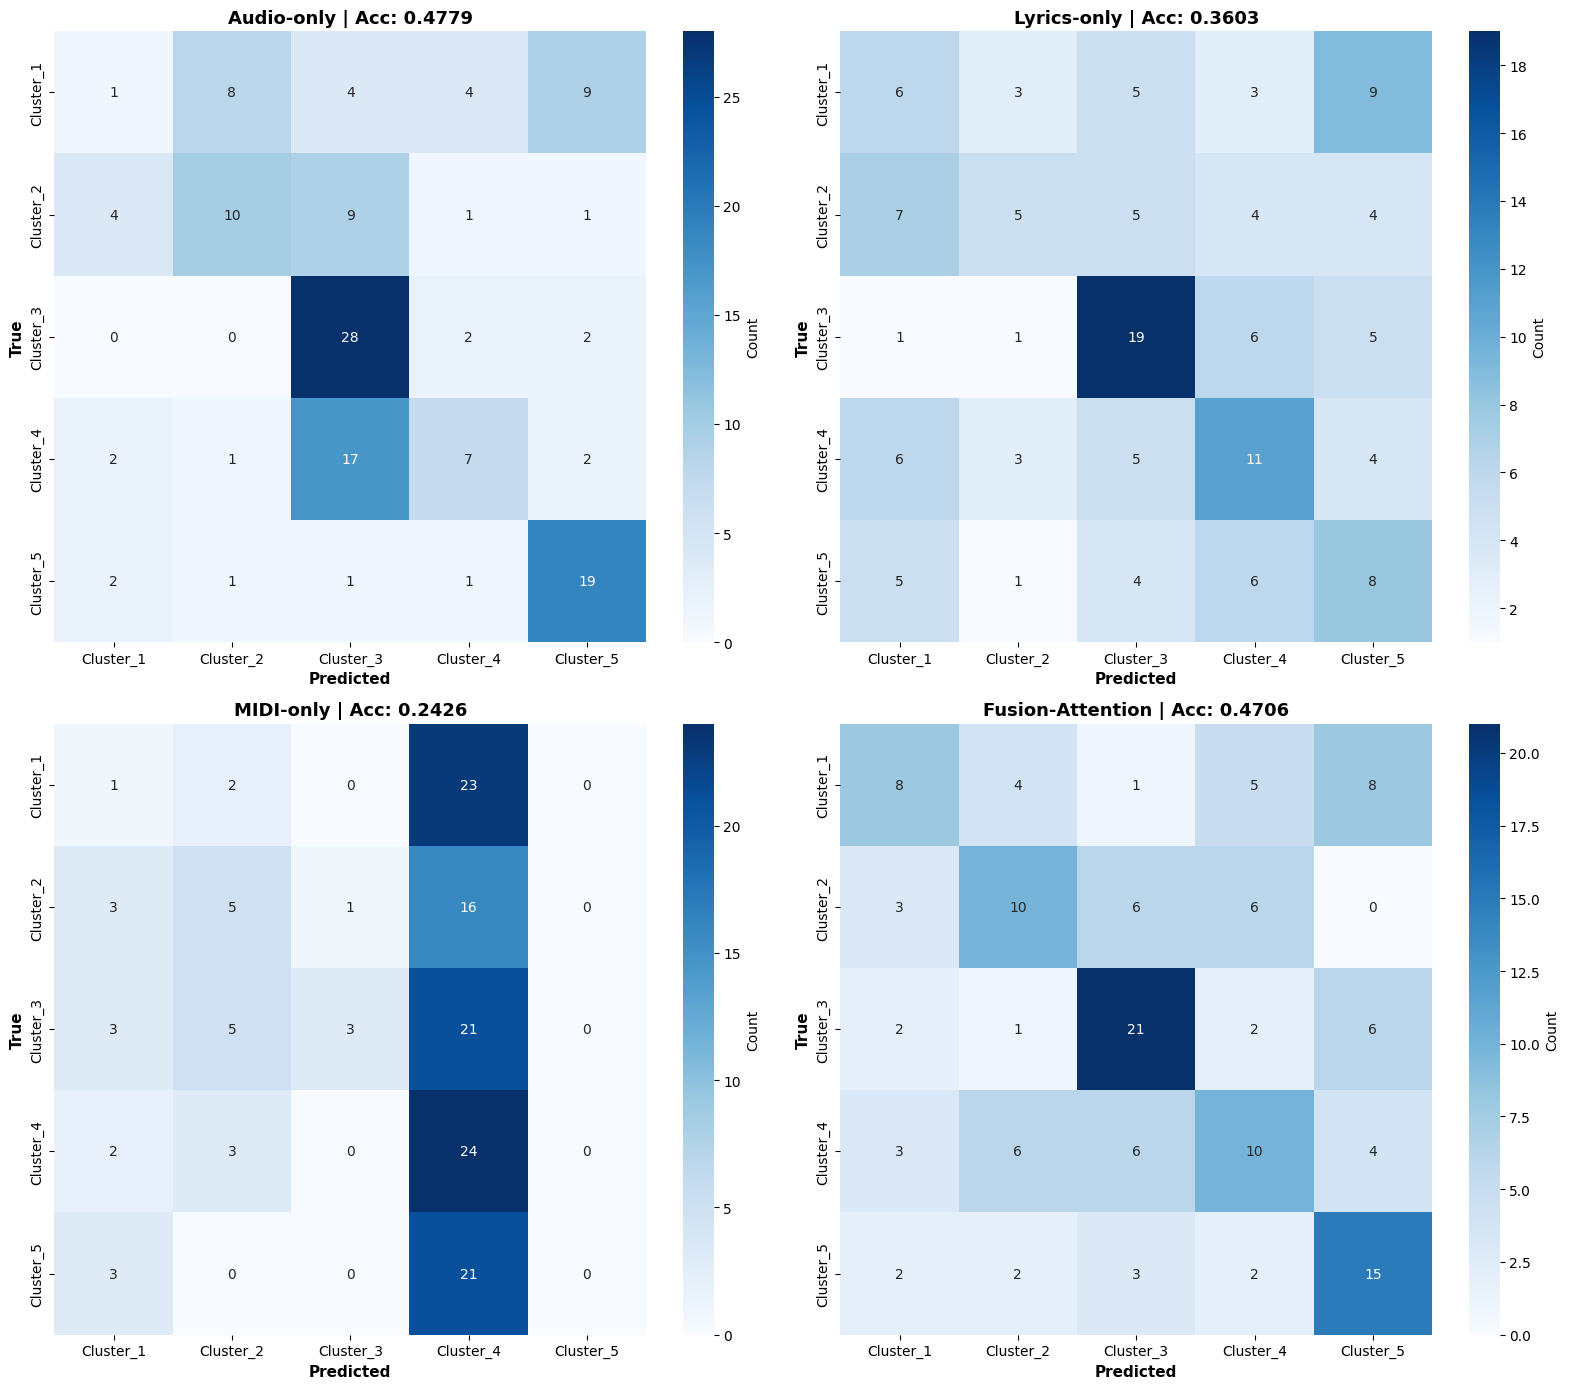

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, (key, title) in enumerate(zip(model_names, titles)):
    ax = axes[idx // 2, idx % 2]
    
    y_true = results[key]['y_true']
    y_pred = results[key]['y_pred']
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=cluster_labels, yticklabels=cluster_labels,
                ax=ax, cbar_kws={'label': 'Count'})
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('True', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} | Acc: {results[key]["test_acc"]:.4f}', 
                 fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [19]:
print("DETAILED ANALYSIS")
print("=" * 80)

print("\nPer-Class F1-Score Comparison:\n")

f1_comparison = pd.DataFrame()

for key, title in zip(['audio', 'lyrics', 'midi', 'attention'], 
                      ['Audio', 'Lyrics', 'MIDI', 'Multimodal']):
    y_true = results[key]['y_true']
    y_pred = results[key]['y_pred']
    
    report = classification_report(y_true, y_pred, target_names=cluster_labels, 
                                   output_dict=True, zero_division=0)
    
    f1_scores = [report[label]['f1-score'] for label in cluster_labels]
    f1_comparison[title] = f1_scores

f1_comparison.index = cluster_labels
print(f1_comparison.to_string())
print()

from scipy import stats

print("\nSTATISTICAL SIGNIFICANCE (Paired t-test)")
print("=" * 80)

best_unimodal_key = max(['audio', 'lyrics', 'midi'], 
                        key=lambda x: results[x]['test_acc'])

print(f"\nComparing: Multimodal vs {results[best_unimodal_key]['model_name']}")

multi_fold_accs = results['attention']['fold_accs']
uni_fold_accs = results[best_unimodal_key]['fold_accs']

t_stat, p_value = stats.ttest_rel(multi_fold_accs, uni_fold_accs)

print(f"Multimodal mean: {np.mean(multi_fold_accs):.4f}")
print(f"{results[best_unimodal_key]['model_name']} mean: {np.mean(uni_fold_accs):.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Statistically significant improvement (p < 0.05)")

else:    print("NOT statistically significant (p >= 0.05)")

DETAILED ANALYSIS

Per-Class F1-Score Comparison:

              Audio    Lyrics      MIDI  Multimodal
Cluster_1  0.057143  0.235294  0.052632    0.363636
Cluster_2  0.444444  0.263158  0.250000    0.416667
Cluster_3  0.615385  0.542857  0.166667    0.608696
Cluster_4  0.318182  0.372881  0.358209    0.370370
Cluster_5  0.666667  0.296296  0.000000    0.526316


STATISTICAL SIGNIFICANCE (Paired t-test)

Comparing: Multimodal vs Audio-only
Multimodal mean: 0.5071
Audio-only mean: 0.4812
t-statistic: 0.6725
p-value: 0.5706
NOT statistically significant (p >= 0.05)


In [20]:
import json

results_summary = {
    'comparison': comparison_df.to_dict('records'),
    'f1_per_class': f1_comparison.to_dict(),
    'statistical_test': {
        'comparison': f"Fusion-Attention vs {results[best_unimodal_key]['model_name']}",
        't_statistic': float(t_stat),
        'p_value': float(p_value),
        'significant': p_value < 0.05
    }
}

with open('comparison_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to 'comparison_results.json'")
print("\nEXPERIMENT COMPLETED")

TypeError: Object of type bool_ is not JSON serializable